## Predicting RBP Binding with CNN and Transformer

### Imports

In [ ]:
import os 
import torch
import torch.nn as nn 
import torch.utils.data
from torch.nn.modules.pooling import MaxPool2d

import numpy as np 
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from pathlib import Path
import random

assert(torch.cuda.is_available())
device = "cuda" 

In [ ]:
!pip install torch 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.4 MB/s eta 0:00:0000:0100:01


In [ ]:
!unzip datasets 

Archive:  datasets.zip
  inflating: datasets/ENCODE/encode_eclip_idr.bed.gz  
  inflating: datasets/rnbs_HNRNPK/HNRNPK_20.fasta.gz  
  inflating: datasets/rnbs_HNRNPK/HNRNPK_5.fasta.gz  
  inflating: datasets/rnbs_HNRNPK/HNRNPK_80.fasta.gz  
  inflating: datasets/rnbs_HNRNPK/HNRNPK_1300.fasta.gz  
  inflating: datasets/rnbs_HNRNPK/HNRNPK_0.fasta.gz  
  inflating: datasets/rnbs_HNRNPK/HNRNPK_320.fasta.gz  


### Datasets

##### ENCODE

In [ ]:
root_dir = '/content/drive/MyDrive/ML4FG/Project' 

In [ ]:
encode_dir = Path('datasets/ENCODE')

encode_df = pd.read_csv(encode_dir / 'encode_eclip_idr.bed.gz', sep = '\t')
encode_df = encode_df.sort_values(['chr', 'start']).drop_duplicates()
encode_df 

,chr,start,end,strand,fold,nlog10p,cell,target
565739,chr1,15922,15985,-,4.336078,6.512251,K562,AQR
494169,chr1,16230,16331,-,3.344423,6.274660,K562,BUD13
562861,chr1,16250,16319,-,4.045827,7.122894,K562,AQR
558839,chr1,16462,16510,-,5.292347,6.083708,K562,AQR
278941,chr1,17451,17573,-,3.361457,4.291127,K562,CSTF2T
...,...,...,...,...,...,...,...,...
438950,chrY,19744401,19744473,-,3.464966,8.168405,HepG2,BCLAF1
191326,chrY,19744489,19744548,-,3.048818,4.066013,HepG2,PPIG
671368,chrY,20579772,20579892,+,4.660723,5.507490,HepG2,U2AF2
159170,chrY,20580800,20580864,+,4.144179,3.393384,HepG2,QKI


In [ ]:
target_set = set(encode_df['target'])
target_to_idx = dict(zip(target_set, list(range(len(target_set)))))
idx_to_target = dict(zip(list(range(len(target_set))), target_set)) 

##### rnbs_HNRNPK

In [ ]:
rnbs_HNRNPK_dir = Path('datasets/rnbs_HNRNPK')

HNRNPK_0 = pd.read_csv(rnbs_HNRNPK_dir / 'HNRNPK_0.fasta.gz', header=None, names = ['Sequence'], sep = '\t')
HNRNPK_0 

,Sequence
0,AGGACCTGACCATACGATGA
1,ACTAAATCTCATGCAGGATA
2,TTATAGCCCGATTAGGAGGG
3,ATCGCCAATTGTCTTCAGAT
4,CATTATCGCTTTATACAACT
...,...
11509893,ACAGTCTGGTTTCGAACGCG
11509894,ACGAAATCTAGAGTAACTTA
11509895,GCCATGAGATCATACGTCTT
11509896,ACTCCACCGTTAGTATCCTT


##### hg38

In [ ]:
genome = pickle.load(open('hg38.pkl',"rb")) 

### Functions


In [ ]:
def train_val_test_split(df):
  chr_set = set(df['chr'])
  valtest_chr_set = set(['chr1', 'chr2', 'chr3'])
  train_chr_set = chr_set - valtest_chr_set

  train_df = df.loc[df['chr'].isin(train_chr_set)]
  val_df = df.loc[df['chr'].isin(['chr2', 'chr3'])]
  test_df = df.loc[df['chr'] == 'chr1']

  return train_df, val_df, test_df


In [ ]:
encode_train, encode_val, encode_test = train_val_test_split(encode_df) 

In [ ]:
def get_longest_seq_len(df):
  start_lst = list(df['start'])
  end_lst = list(df['end'])
  seq_len = [end - start for start, end in zip(start_lst, end_lst)] 
  max_seq_len = list(set(seq_len))[-1]

  return max_seq_len


In [ ]:
max_seq_len = get_longest_seq_len(encode_df) 

In [ ]:
def one_hot(seq):
  d = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

  one_hot_enc = np.zeros((4, len(seq)))

  for i in range(len(seq)):
    el = seq[i]
    if el != 'N':
      one_hot_enc[d[el], i] = 1.0

  return one_hot_enc 


In [ ]:
def pad_enc(one_hot_enc, max_seq_len):
  padded_enc = np.zeros((4, max_seq_len))
  padded_enc[:, 0:one_hot_enc.shape[1]] = one_hot_enc
  
  return padded_enc 


In [ ]:
# convert negative strand to its positive equivalence
def strand_normalize(seq):
  d = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N':'N'}

  modified_seq =''

  for el in seq:
    modified_seq += d[el]

  return modified_seq 
  

In [ ]:
def collect_positive_samples(df):
  start_lst = list(df['start'])
  end_lst = list(df['end'])
  chr_lst = list(df['chr'])
  strand_lst = list(df['strand'])

  positive_samples = list()

  for i in range(df.shape[0]):
    current_start, current_end = start_lst[i], end_lst[i]

    if i == 0:
      positive_samples.append([chr_lst[i], (start_lst[i], end_lst[i]), strand_lst[i]])

    else:
      previous_start, previous_end = positive_samples[-1][1]

      if previous_end < current_start or chr_lst[i-1] != chr_lst[i]:
        positive_samples.append([chr_lst[i], (current_start, current_end), strand_lst[i]])

      else:
        positions = [previous_start, previous_end, current_start, current_end]
        positions.sort()

        positive_samples[-1] = [chr_lst[i-1], (positions[0], positions[-1]), strand_lst[i-1]]

  return positive_samples 
  

In [ ]:
train_positive_samples = collect_positive_samples(encode_train)  
val_positive_samples = collect_positive_samples(encode_val)
test_positive_samples = collect_positive_samples(encode_test) 

In [ ]:
train_positive_samples 

[['chr10', (135545, 135676), '+'],
 ['chr10', (135729, 135801), '+'],
 ['chr10', (135816, 136082), '+'],
 ['chr10', (136291, 136342), '+'],
 ['chr10', (136353, 136441), '+'],
 ['chr10', (136541, 136609), '+'],
 ['chr10', (136647, 136717), '+'],
 ['chr10', (153358, 153406), '+'],
 ['chr10', (160419, 160479), '+'],
 ['chr10', (164259, 164406), '+'],
 ['chr10', (165435, 165593), '+'],
 ['chr10', (174516, 174642), '+'],
 ['chr10', (179976, 180049), '+'],
 ['chr10', (180059, 180127), '+'],
 ['chr10', (184656, 184768), '+'],
 ['chr10', (199226, 199385), '+'],
 ['chr10', (211483, 211592), '+'],
 ['chr10', (221619, 221704), '+'],
 ['chr10', (254444, 254558), '+'],
 ['chr10', (282044, 282111), '-'],
 ['chr10', (321293, 321386), '-'],
 ['chr10', (321425, 321556), '-'],
 ['chr10', (322940, 322988), '-'],
 ['chr10', (323237, 323281), '-'],
 ['chr10', (323483, 323515), '-'],
 ['chr10', (323981, 324107), '-'],
 ['chr10', (326933, 327055), '-'],
 ['chr10', (336738, 336925), '-'],
 ['chr10', (337174, 

In [ ]:
def collect_negative_samples(positive_samples):
    negative_samples = list()
    for i in range(len(positive_samples)-1):
        if positive_samples[i][0] == positive_samples[i+1][0]:
            start = positive_samples[i][1][1]
            end = positive_samples[i+1][1][0]
            
            chrom = positive_samples[i][0]
            negative_samples.append([chrom, (start, end)])
        
    return negative_samples 


In [ ]:
train_negative_samples = collect_negative_samples(train_positive_samples) 
val_negative_samples = collect_negative_samples(val_positive_samples)
test_negative_samples = collect_negative_samples(test_positive_samples) 

In [ ]:
train_negative_samples 

[['chr10', (135676, 135729)],
 ['chr10', (135801, 135816)],
 ['chr10', (136082, 136291)],
 ['chr10', (136342, 136353)],
 ['chr10', (136441, 136541)],
 ['chr10', (136609, 136647)],
 ['chr10', (136717, 153358)],
 ['chr10', (153406, 160419)],
 ['chr10', (160479, 164259)],
 ['chr10', (164406, 165435)],
 ['chr10', (165593, 174516)],
 ['chr10', (174642, 179976)],
 ['chr10', (180049, 180059)],
 ['chr10', (180127, 184656)],
 ['chr10', (184768, 199226)],
 ['chr10', (199385, 211483)],
 ['chr10', (211592, 221619)],
 ['chr10', (221704, 254444)],
 ['chr10', (254558, 282044)],
 ['chr10', (282111, 321293)],
 ['chr10', (321386, 321425)],
 ['chr10', (321556, 322940)],
 ['chr10', (322988, 323237)],
 ['chr10', (323281, 323483)],
 ['chr10', (323515, 323981)],
 ['chr10', (324107, 326933)],
 ['chr10', (327055, 336738)],
 ['chr10', (336925, 337174)],
 ['chr10', (337413, 337427)],
 ['chr10', (337528, 337581)],
 ['chr10', (337787, 337802)],
 ['chr10', (337946, 344767)],
 ['chr10', (344832, 345451)],
 ['chr10',

In [ ]:
def get_negative_sample(negative_samples, context_length):
    idx = random.randint(0, len(negative_samples)-1)
    sample = negative_samples[idx]
    
    chrom = sample[0]
    start, end = sample[1]
    
    if start < end-context_length+1:
        rand_start = random.randint(start, end-context_length+1)
        return [chrom, (rand_start, rand_start+context_length)]  
    else:
        midpoint = int(.5 * (start + end))
        return [chrom, (midpoint - context_length//2, midpoint + context_length//2)] 

In [ ]:
def get_positive_label(target, target_to_idx):
    return target_to_idx[target] 
  

In [ ]:
def mtx_to_idx_label(mtx):
  indices = torch.zeros(mtx.shape[0], dtype=torch.int)
  for i in range(mtx.shape[0]):
    row = mtx[i,:]
    indices[i] = list(row).index(1)

  return indices 
  

### Multiclass Classification

### Base Dataloader

In [ ]:
class BedPeaksDataset(torch.utils.data.IterableDataset):

    def __init__(self, eclip_data, genome, context_length, target_to_idx):
        super(BedPeaksDataset, self).__init__()
        self.eclip_data = eclip_data
        self.genome = genome
        self.context_length = context_length
        self.target_to_idx = target_to_idx 

    def __iter__(self): 
        for i,row in enumerate(self.eclip_data.itertuples()):
            midpoint = int(.5 * (row.start + row.end))
            seq = self.genome[row.chr][midpoint - self.context_length//2:midpoint + self.context_length//2]
            if row.strand == '-':
              seq = strand_normalize(seq)
            yield(one_hot(seq), get_positive_label(row.target, self.target_to_idx)) 


    def __len__(self):
        return self.eclip_data.shape[0]


In [ ]:
context_length = 100

encode_train_dataset = BedPeaksDataset(encode_train, genome, context_length, target_to_idx)
encode_train_dataloader = torch.utils.data.DataLoader(encode_train_dataset, batch_size=1028, num_workers = 0) 

encode_val_dataset = BedPeaksDataset(encode_val, genome, context_length, target_to_idx)
encode_val_dataloader = torch.utils.data.DataLoader(encode_val_dataset, batch_size=1028)

encode_test_dataset = BedPeaksDataset(encode_test, genome, context_length, target_to_idx)
encodetest_dataloader = torch.utils.data.DataLoader(encode_test_dataset, batch_size=1028) 

### Convolutional Neural Network

In [ ]:
class ConvBasicNet(nn.Module): 

    def __init__(self, padding=False):
        super().__init__()

        self.padding = padding
        self.conv_model = self.get_conv_layers()
        self.final_max_pool = self.final_pool_layer()
        self.fc_model = self.get_fc_layers()

    def get_conv_layers(self):
        
        layers = nn.Sequential(
            nn.Conv1d(4, 32, 5),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2, 2),
            nn.ReLU(),
            nn.Conv1d(32, 16, 5),
            nn.BatchNorm1d(16),
            nn.MaxPool1d(2, 2),
            nn.ReLU()
        )

        return layers

    def final_pool_layer(self):
        
        layer = nn.MaxPool1d(2, 2) 
        
        return layer

    def get_fc_layers(self):
        
        if self.padding==False:
          layers = nn.Sequential(
              nn.Linear(176, 512),
              nn.ReLU(),
              nn.Linear(512, 1024),
              nn.ReLU(),
              nn.Linear(1024, 150)
          )

        elif self.padding:
          layers = nn.Sequential(
              nn.Linear(912, 1024),
              nn.ReLU(),
              nn.Linear(1024, 2048),
              nn.ReLU(),
              nn.Linear(2048, 150)
          )

        return layers

    def register_grad_hook(self, grad):
        self.grad = grad 


    def forward(self, x):

        x = self.conv_model(x) 
        h = x.register_hook(self.register_grad_hook)

        x = self.final_max_pool(x)
        x = nn.Flatten()(x) 
        x = self.fc_model(x)

        return x    

    def get_gradient_activations(self):
        return self.grad

    def get_final_conv_layer(self, x):
        return self.conv_model(x) 


In [ ]:
class Classifier():

    def __init__(self, name, model, dataloaders, class_names, use_cuda=False):
        
        '''
        @name: Experiment name. Will define stored results etc. 
        @model: GradBasicNet()
        @dataloaders: Dictionary with keys train, val and test and corresponding dataloaders
        @class_names: list of classes, where the idx of class name corresponds to the label used for it in the data
        @use_cuda: whether or not to use cuda
        '''
        
        self.name = name
        if use_cuda and not torch.cuda.is_available():
            raise Exception("Asked for CUDA but GPU not found")
            
        self.use_cuda = use_cuda
        self.model = model.to('cuda' if use_cuda else 'cpu')

        self.criterion = nn.CrossEntropyLoss()
        self.optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        self.dataloaders = dataloaders 
        self.class_names = class_names
        self.activations_path = os.path.join('activations', self.name)
        self.kernel_path = os.path.join('kernel_viz', self.name)

        save_path = os.path.join(os.getcwd(), 'models', self.name)
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        if not os.path.exists(self.activations_path):
            os.makedirs(self.activations_path)

        if not os.path.exists(self.kernel_path):
            os.makedirs(self.kernel_path)
            
        self.save_path = save_path

    def train(self, epochs, save=True):
        '''
        @epochs: number of epochs to train
        @save: whether or not to save the checkpoints
        '''

        self.epoch_accuracies = list()

        best_val_accuracy = - math.inf

        for epoch in range(epochs):

            self.model.train()

            batches_in_pass = len(self.dataloaders['train'])
            
            epoch_loss = 0.0 # Record the total loss for each epoch
            
            for idx, data in enumerate(self.dataloaders['train']):
               
              inputs, labels = data
            
              inputs = inputs.to('cuda', dtype=torch.float if self.use_cuda else 'cpu') 
              labels = labels.to('cuda', dtype=torch.int64 if self.use_cuda else 'cpu')
            
              outputs = self.model(inputs)            
              train_loss = self.criterion(outputs, labels)

              epoch_loss += train_loss 

              self.optim.zero_grad()
              train_loss.backward() 
              self.optim.step()

            '''Give validation'''
            epoch_loss /= batches_in_pass

            self.model.eval()
            
            #DO NOT modify this part
            correct = 0.0
            total = 0.0
            for idx, data in enumerate(self.dataloaders['val']):

                inputs, labels = data
                
                inputs = inputs.to('cuda', dtype=torch.float if self.use_cuda else 'cpu')
                labels = labels.to('cuda', dtype=torch.int64 if self.use_cuda else 'cpu')

                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)

                total += labels.shape[0]
                correct += (predicted == labels).sum().item()


            epoch_accuracy = 100 * correct / total
            
            self.epoch_accuracies.append(epoch_accuracy)
            
            print(f'Train Epoch Loss (Avg): {epoch_loss}')
            print(f'Validation Epoch Accuracy:{epoch_accuracy}')
            
            if save:
                
                torch.save(self.model.state_dict(), os.path.join(self.save_path, f'epoch_{epoch}.pt'))
                
                if epoch_accuracy > best_val_accuracy:

                    torch.save(self.model.state_dict(), os.path.join(self.save_path, 'best.pt'))
                    print('save model', os.path.join(self.save_path, f'epoch_{epoch}.pt'))
                    best_val_accuracy = epoch_accuracy

        print('Finish training!')                       

    
    def evaluate(self):
        
        try:
            assert os.path.exists(os.path.join(self.save_path, 'best.pt'))
            
        except:
            print('It appears you are testing the model without training. Please train first')
            return
        
        self.model.load_state_dict(torch.load(os.path.join(self.save_path, 'best.pt')))
        self.model.eval()

        total = len(self.dataloaders['test'])
        
        correct = 0.0
        total = 0.0
        for idx, data in enumerate(self.dataloaders['test']):
            
            inputs, labels = data
            inputs = inputs.to('cuda', dtype=torch.float if self.use_cuda else 'cpu')
            labels = labels.to('cuda', dtype=torch.int64 if self.use_cuda else 'cpu')

            outputs = self.model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
                
        print(f'Accuracy: {100 * correct/total}%')
        

In [ ]:
experiment_name = 'basic' 
model_name = 'basic' 

dataloaders = {'train': encode_train_dataloader, 'val' : encode_val_dataloader, 'test': encode_train_dataloader, 'mapping': target_set}
model = ConvBasicNet()
classifier1 = Classifier(experiment_name, model, dataloaders, target_set, use_cuda=True) 

In [ ]:
classifier1.train(epochs=100)
classifier1.evaluate() 

Train Epoch Loss (Avg): 4.414685249328613
Validation Epoch Accuracy:11.560257949247648
save model /home/wh2500/models/basic/epoch_0.pt
Train Epoch Loss (Avg): 4.1142897605896
Validation Epoch Accuracy:14.84045671533458
save model /home/wh2500/models/basic/epoch_1.pt
Train Epoch Loss (Avg): 3.920497179031372
Validation Epoch Accuracy:15.877092580702195
save model /home/wh2500/models/basic/epoch_2.pt
Train Epoch Loss (Avg): 3.8512961864471436
Validation Epoch Accuracy:16.260480351376753
save model /home/wh2500/models/basic/epoch_3.pt
Train Epoch Loss (Avg): 3.8104710578918457
Validation Epoch Accuracy:16.669923601611718
save model /home/wh2500/models/basic/epoch_4.pt
Train Epoch Loss (Avg): 3.7773847579956055
Validation Epoch Accuracy:17.03376976261597
save model /home/wh2500/models/basic/epoch_5.pt
Train Epoch Loss (Avg): 3.747227907180786
Validation Epoch Accuracy:17.44786577705815
save model /home/wh2500/models/basic/epoch_6.pt
Train Epoch Loss (Avg): 3.718804359436035
Validation Epoc

In [ ]:
cnn_val_accs = classifier1.epoch_accuracies 
print(cnn_val_accs) 

[11.560257949247648, 14.84045671533458, 15.877092580702195, 16.260480351376753, 16.669923601611718, 17.03376976261597, 17.44786577705815, 17.804267515330856, 18.169974782018, 18.580348585094406, 18.841833933539917, 19.13402752575305, 19.382485134418356, 19.58999841806017, 19.76959511645869, 19.883122563114746, 19.975247294417613, 20.085052529707898, 20.152052334291803, 20.223704903082922, 20.260927016740645, 20.300010236081256, 20.378176674762475, 20.422843211151744, 20.47867638163833, 20.558703926002437, 20.62291207206201, 20.681536901072928, 20.735508965876626, 20.750397811339717, 20.81460595739929, 20.87695299777598, 20.95791109498153, 21.021188688199658, 21.09656346835655, 21.14774387463592, 21.193340963866632, 21.24638247582889, 21.278021272437954, 21.33385444292454, 21.380382084996697, 21.412951434447205, 21.4538957594707, 21.481812344713994, 21.509728929957287, 21.521826116896047, 21.5618398890781, 21.591617580004282, 21.59720089705294, 21.641867433442208, 21.68095065278282, 21.

In [ ]:
!git clone https://github.com/xypan1232/iDeepS 

Cloning into 'iDeepS'...
remote: Enumerating objects: 9858, done.
remote: Total 9858 (delta 0), reused 0 (delta 0), pack-reused 9858
Receiving objects: 100% (9858/9858), 547.92 MiB | 12.15 MiB/s, done.
Resolving deltas: 100% (3603/3603), done.
Checking out files: 100% (3530/3530), done.


### CNN with various input lengths (padded)

In [ ]:
class VariedBedPeaksDataset(torch.utils.data.IterableDataset):

    def __init__(self, eclip_data, genome, max_seq_len, target_to_idx):
        super(VariedBedPeaksDataset, self).__init__()
        self.eclip_data = eclip_data
        self.genome = genome
        self.max_seq_len = max_seq_len
        self.target_to_idx = target_to_idx 

    def __iter__(self): 
        for i,row in enumerate(self.eclip_data.itertuples()):
            midpoint = int(.5 * (row.start + row.end))
            seq = self.genome[row.chr][row.start:row.end]
            if row.strand == '-':
              seq = strand_normalize(seq) 
            yield(pad_enc(one_hot(seq), self.max_seq_len), get_positive_label(row.target, self.target_to_idx)) # positive example 


    def __len__(self):
        return self.eclip_data.shape[0]


In [ ]:
encode_train_dataset = VariedBedPeaksDataset(encode_train, genome, max_seq_len, target_to_idx)
encode_train_dataloader = torch.utils.data.DataLoader(encode_train_dataset, batch_size=1028, num_workers = 0) 

encode_val_dataset = VariedBedPeaksDataset(encode_val, genome, max_seq_len, target_to_idx)
encode_val_dataloader = torch.utils.data.DataLoader(encode_val_dataset, batch_size=1028)

encode_test_dataset = VariedBedPeaksDataset(encode_test, genome, max_seq_len, target_to_idx)
encodetest_dataloader = torch.utils.data.DataLoader(encode_test_dataset, batch_size=1028) 

In [ ]:
experiment_name = 'basic_pad'  #Provide name to model experiment
model_name = 'basic_pad' 

dataloaders = {'train': encode_train_dataloader, 'val' : encode_val_dataloader, 'test': encode_train_dataloader, 'mapping': target_set}
model = ConvBasicNet(padding=True)
classifier2 = Classifier(experiment_name, model, dataloaders, target_set, use_cuda=True) 

In [ ]:
classifier2.train(epochs=100)
classifier2.evaluate() 

Train Epoch Loss (Avg): 4.312549591064453
Validation Epoch Accuracy:12.586657733359388
save model /home/wh2500/models/basic_pad/epoch_0.pt
Train Epoch Loss (Avg): 3.954946756362915
Validation Epoch Accuracy:16.051105962052056
save model /home/wh2500/models/basic_pad/epoch_1.pt
Train Epoch Loss (Avg): 3.8185360431671143
Validation Epoch Accuracy:16.807645422145296
save model /home/wh2500/models/basic_pad/epoch_2.pt
Train Epoch Loss (Avg): 3.7595598697662354
Validation Epoch Accuracy:17.344574411657966
save model /home/wh2500/models/basic_pad/epoch_3.pt
Train Epoch Loss (Avg): 3.7169158458709717
Validation Epoch Accuracy:17.6432818737612
save model /home/wh2500/models/basic_pad/epoch_4.pt
Train Epoch Loss (Avg): 3.680737018585205
Validation Epoch Accuracy:17.617226394200795
Train Epoch Loss (Avg): 3.6501357555389404
Validation Epoch Accuracy:17.602337548737705
Train Epoch Loss (Avg): 3.6250531673431396
Validation Epoch Accuracy:17.548365483934006
Train Epoch Loss (Avg): 3.605546474456787

In [ ]:
cnn_padding_val_accs = classifier2.epoch_accuracies 
print(cnn_padding_val_accs) 

[12.586657733359388, 16.051105962052056, 16.807645422145296, 17.344574411657966, 17.6432818737612, 17.617226394200795, 17.602337548737705, 17.548365483934006, 17.67212901184594, 17.874989531280534, 18.006197481924012, 18.205335789992834, 18.352363138940845, 18.481709983901435, 18.61198738170347, 18.661306682299955, 18.77111191759024, 18.892083786977842, 18.969319672817623, 19.03445837171864, 19.133096972911606, 19.20940230590994, 19.323860305407443, 19.45134604468515, 19.50904032085462, 19.608609474889032, 19.67095651526572, 19.771456222141573, 19.852414319347123, 19.924997440979688, 20.001302773978022, 20.07016368424481, 20.10924690358542, 20.1864827894252, 20.240454854228897, 20.3139685287029, 20.347468430994855, 20.401440495798553, 20.43307929240762, 20.464718089016685, 20.500079096991524, 20.500079096991524, 20.54195397485646, 20.602439909550263, 20.656411974353965, 20.67967579539004, 20.70573127495045, 20.73364786019374, 20.753189469864047, 20.764356103961365, 20.788550477838886, 

### CNN + LSTM

In [ ]:
class ConvLSTMNet(nn.Module): 

    def __init__(self):
        super().__init__()

        self.conv_model = self.get_conv_layers()
        self.final_max_pool = self.final_pool_layer()
        self.lstm_model = self.lstm_layer()
        self.fc_model = self.get_fc_layers()

    def get_conv_layers(self):
        
        layers = nn.Sequential(
            nn.Conv1d(4, 32, 5),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2, 2),
            nn.ReLU(),
            nn.Conv1d(32, 16, 5),
            nn.BatchNorm1d(16),
            nn.MaxPool1d(2, 2),
            nn.ReLU()
        )

        return layers

    def final_pool_layer(self):
        
        layer = nn.MaxPool1d(2, 2) 
        
        return layer

    def lstm_layer(self):
        
        layer = nn.LSTM(input_size=11, hidden_size=8, num_layers=2, batch_first=True) 

        return layer 

    def get_fc_layers(self):
        
        layers = nn.Sequential(
            nn.Linear(in_features=128, out_features=256),
            nn.Linear(in_features=256, out_features=150)
        )

        return layers 

    def register_grad_hook(self, grad):
        self.grad = grad 


    def forward(self, x):

        x = self.conv_model(x) 
        h = x.register_hook(self.register_grad_hook)

        x = self.final_max_pool(x)
        x = self.lstm_model(x)[0]
        x = nn.Flatten()(x) 
        x = self.fc_model(x) 

        return x    

    def get_gradient_activations(self):
        return self.grad

    def get_final_conv_layer(self, x):
        return self.conv_model(x) 


In [ ]:
experiment_name = 'cnn_lstm' 
model_name = 'cnn_lstm' 

dataloaders = {'train': encode_train_dataloader, 'val' : encode_val_dataloader, 'test': encode_train_dataloader, 'mapping': target_set}
model = ConvLSTMNet()
classifier3 = Classifier(experiment_name, model, dataloaders, target_set, use_cuda=True) 

In [ ]:
classifier3.train(epochs=100)
classifier3.evaluate() 

Train Epoch Loss (Avg): 4.68993616104126
Validation Epoch Accuracy:2.150507616575007
save model /home/wh2500/models/cnn_lstm/epoch_0.pt
Train Epoch Loss (Avg): 4.3687639236450195
Validation Epoch Accuracy:2.150507616575007
Train Epoch Loss (Avg): 4.349669456481934
Validation Epoch Accuracy:2.150507616575007
Train Epoch Loss (Avg): 4.345366477966309
Validation Epoch Accuracy:2.150507616575007
Train Epoch Loss (Avg): 4.343350887298584
Validation Epoch Accuracy:2.150507616575007
Train Epoch Loss (Avg): 4.341891765594482
Validation Epoch Accuracy:2.150507616575007
Train Epoch Loss (Avg): 4.3404459953308105
Validation Epoch Accuracy:2.150507616575007
Train Epoch Loss (Avg): 4.33860445022583
Validation Epoch Accuracy:2.150507616575007
Train Epoch Loss (Avg): 4.335755825042725
Validation Epoch Accuracy:2.150507616575007
Train Epoch Loss (Avg): 4.330350399017334
Validation Epoch Accuracy:2.150507616575007
Train Epoch Loss (Avg): 4.317098617553711
Validation Epoch Accuracy:6.654383369159618
sav

In [ ]:
cnn_rnn_val_accs = classifier3.epoch_accuracies
print(cnn_rnn_val_accs) 

[2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 6.654383369159618, 8.384281101402344, 9.326931129784205, 10.35798367810316, 10.713454863534427, 11.942715167080763, 12.911420675023031, 13.659585159543285, 14.633873984534212, 15.414607818504974, 15.904078613104046, 16.30235522924169, 16.642937569209867, 16.980728250653712, 17.27385239570829, 17.42367140318063, 17.57349041065297, 17.743781580637055, 17.86754510854899, 18.016433563179884, 18.145780408140475, 18.267682830369523, 18.352363138940845, 18.43146013046351, 18.47426556116989, 18.57941803225296, 18.639903966946765, 18.703181560164893, 18.755292519285707, 18.805542372723636, 18.837181169332702, 18.90325042107516, 18.92744479495268, 18.97304188418339, 18.9990973637438, 19.013055656365445, 19.030736160352866, 19.06516661548626, 19.095874859253883, 19.126583103021506, 19.1610135581549, 19.221499

In [ ]:
cnn_val_accs = [11.560257949247648, 14.84045671533458, 15.877092580702195, 16.260480351376753, 16.669923601611718, 17.03376976261597, 17.44786577705815, 17.804267515330856, 18.169974782018, 18.580348585094406, 18.841833933539917, 19.13402752575305, 19.382485134418356, 19.58999841806017, 19.76959511645869, 19.883122563114746, 19.975247294417613, 20.085052529707898, 20.152052334291803, 20.223704903082922, 20.260927016740645, 20.300010236081256, 20.378176674762475, 20.422843211151744, 20.47867638163833, 20.558703926002437, 20.62291207206201, 20.681536901072928, 20.735508965876626, 20.750397811339717, 20.81460595739929, 20.87695299777598, 20.95791109498153, 21.021188688199658, 21.09656346835655, 21.14774387463592, 21.193340963866632, 21.24638247582889, 21.278021272437954, 21.33385444292454, 21.380382084996697, 21.412951434447205, 21.4538957594707, 21.481812344713994, 21.509728929957287, 21.521826116896047, 21.5618398890781, 21.591617580004282, 21.59720089705294, 21.641867433442208, 21.68095065278282, 21.70514502666034, 21.747019904525278, 21.773075384085686, 21.791686440914546, 21.802853075011864, 21.820533578999285, 21.8251863432065, 21.848450164242575, 21.88288061937597, 21.90428333472916, 21.92754715576524, 21.95732484669142, 22.01222746433656, 22.021532992750995, 22.05038013083573, 22.07178284618892, 22.114588276895304, 22.125754910992622, 22.14343541498004, 22.165768683174672, 22.20019913830807, 22.223462959344147, 22.25417120311177, 22.297907186659593, 22.304421056549696, 22.312796032122684, 22.33512930031732, 22.366768096926386, 22.403059657742666, 22.42818458446163, 22.44679564129049, 22.459823381070695, 22.48867051915543, 22.504489917459964, 22.526823185654596, 22.53426760838614, 22.54822590100779, 22.550087006690674, 22.57893414477541, 22.60871183570159, 22.610572941384476, 22.633836762420554, 22.660822794822405, 22.670128323236835, 22.70083656700446, 22.718517070991876, 22.748294761918057, 22.779003005685677, 22.790169639782995]
cnn_padding_val_accs = [12.586657733359388, 16.051105962052056, 16.807645422145296, 17.344574411657966, 17.6432818737612, 17.617226394200795, 17.602337548737705, 17.548365483934006, 17.67212901184594, 17.874989531280534, 18.006197481924012, 18.205335789992834, 18.352363138940845, 18.481709983901435, 18.61198738170347, 18.661306682299955, 18.77111191759024, 18.892083786977842, 18.969319672817623, 19.03445837171864, 19.133096972911606, 19.20940230590994, 19.323860305407443, 19.45134604468515, 19.50904032085462, 19.608609474889032, 19.67095651526572, 19.771456222141573, 19.852414319347123, 19.924997440979688, 20.001302773978022, 20.07016368424481, 20.10924690358542, 20.1864827894252, 20.240454854228897, 20.3139685287029, 20.347468430994855, 20.401440495798553, 20.43307929240762, 20.464718089016685, 20.500079096991524, 20.500079096991524, 20.54195397485646, 20.602439909550263, 20.656411974353965, 20.67967579539004, 20.70573127495045, 20.73364786019374, 20.753189469864047, 20.764356103961365, 20.788550477838886, 20.809022640350634, 20.85275862389846, 20.865786363678662, 20.870439127885877, 20.890911290397625, 20.904869583019273, 20.91045290006793, 20.916966769958034, 20.93371672110401, 20.948605566567096, 20.93464727394545, 20.935577826786893, 20.942091696676997, 20.953258330774315, 20.972799940444617, 20.978383257493277, 20.963494412030187, 20.984897127383377, 20.989549891590595, 20.99141099727348, 20.98210546885905, 20.98861933874915, 21.010952606943786, 21.011883159785228, 21.013744265468116, 21.008160948419455, 21.022119241041104, 21.01839702967533, 21.011883159785228, 21.009091501260897, 21.035146980821306, 21.022119241041104, 21.043521956394294, 21.045383062077182, 21.045383062077182, 21.055619143333054, 21.03700808650419, 21.055619143333054, 21.02956366377265, 21.040730297869963, 21.062133013223157, 21.02677200524832, 21.055619143333054, 21.0630635660646, 21.034216427979864, 21.04910527344295, 21.055619143333054, 21.062133013223157, 21.077021858686244]
cnn_rnn_val_accs = [2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 2.150507616575007, 6.654383369159618, 8.384281101402344, 9.326931129784205, 10.35798367810316, 10.713454863534427, 11.942715167080763, 12.911420675023031, 13.659585159543285, 14.633873984534212, 15.414607818504974, 15.904078613104046, 16.30235522924169, 16.642937569209867, 16.980728250653712, 17.27385239570829, 17.42367140318063, 17.57349041065297, 17.743781580637055, 17.86754510854899, 18.016433563179884, 18.145780408140475, 18.267682830369523, 18.352363138940845, 18.43146013046351, 18.47426556116989, 18.57941803225296, 18.639903966946765, 18.703181560164893, 18.755292519285707, 18.805542372723636, 18.837181169332702, 18.90325042107516, 18.92744479495268, 18.97304188418339, 18.9990973637438, 19.013055656365445, 19.030736160352866, 19.06516661548626, 19.095874859253883, 19.126583103021506, 19.1610135581549, 19.2214994928487, 19.273610451969514, 19.33130472813899, 19.375971264528257, 19.387137898625575, 19.433665540697728, 19.49415147539153, 19.531373589049256, 19.573248466914194, 19.61698445046202, 19.65048435275397, 19.67374817379005, 19.718414710179317, 19.750984059629825, 19.79378949033621, 19.806817230116412, 19.82728939262816, 19.858928189237226, 19.871025376175986, 19.90824748983371, 19.931511310869787, 19.943608497808547, 19.951983473381535, 19.99292779840503, 20.001302773978022, 20.026427700696985, 20.060858155830378, 20.077608106976356, 20.111108009268307, 20.12506630188995, 20.128788513255724, 20.128788513255724, 20.13344127746294, 20.1455384644017, 20.159496757023348, 20.206954951936947, 20.19671887068107, 20.221843797400034, 20.225566008765806, 20.2534825940091, 20.274885309362293, 20.29535747187404, 20.319551845751562, 20.329787927007434, 20.345607325311967, 20.366079487823715, 20.372593357713818, 20.40330160148144, 20.41819044694453]

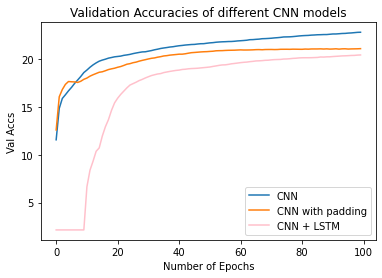

In [ ]:
plt.plot(cnn_val_accs, label='CNN')
plt.plot(cnn_padding_val_accs, label="CNN with padding")
plt.plot(cnn_rnn_val_accs, color = 'pink', label='CNN + LSTM')
plt.plot()
plt.legend() 
#plt.grid(which='both') 

plt.title('Validation Accuracies of different CNN models')
plt.xlabel('Number of Epochs')
plt.ylabel('Val Accs') 

plt.savefig('val_accs_CNN.png', dpi=300)

### Binary Classification

In [ ]:
class BinaryConvBasicNet(nn.Module): 

    def __init__(self, padding=False):
        super().__init__()

        self.padding = padding
        self.conv_model = self.get_conv_layers()
        self.final_max_pool = self.final_pool_layer()
        self.fc_model = self.get_fc_layers()

    def get_conv_layers(self):
        
        layers = nn.Sequential(
            nn.Conv1d(4, 32, 5),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2, 2),
            nn.ReLU(),
            nn.Conv1d(32, 16, 5),
            nn.BatchNorm1d(16),
            nn.MaxPool1d(2, 2),
            nn.ReLU()
        )

        return layers

    def final_pool_layer(self):
        
        layer = nn.MaxPool1d(2, 2) 
        
        return layer

    def get_fc_layers(self):
        
        if self.padding==False:
          layers = nn.Sequential(
              nn.Linear(176, 512),
              nn.ReLU(),
              nn.Linear(512, 1028),
              nn.ReLU(),
              nn.Linear(1028, 2)
          )

        elif self.padding:
          layers = nn.Sequential(
              nn.Linear(912, 1024),
              nn.ReLU(),
              nn.Linear(1024, 2048),
              nn.ReLU(),
              nn.Linear(2048, 2)
          )

        return layers

    def register_grad_hook(self, grad):
        self.grad = grad 


    def forward(self, x):

        x = self.conv_model(x) 
        h = x.register_hook(self.register_grad_hook)

        x = self.final_max_pool(x)
        x = nn.Flatten()(x) 
        x = self.fc_model(x)

        return x    

    def get_gradient_activations(self):
        return self.grad

    def get_final_conv_layer(self, x):
        return self.conv_model(x) 


### Negative Sampling

In [ ]:
class BinaryBedPeaksDataset(torch.utils.data.IterableDataset):

    def __init__(self, eclip_data, genome, context_length, negative_samples):
        super(BinaryBedPeaksDataset, self).__init__()
        self.eclip_data = eclip_data
        self.genome = genome
        self.context_length = context_length
        self.negative_samples = negative_samples 

    def __iter__(self): 
        
        for i,row in enumerate(self.eclip_data.itertuples()):
            rand = random.random()
            if rand <= 0.5:
                midpoint = int(.5 * (row.start + row.end))
                seq = self.genome[row.chr][midpoint - self.context_length//2 : midpoint + self.context_length//2]
                
                if row.strand == '-':
                    seq = strand_normalize(seq)
                
                yield(one_hot(seq), np.int64(1)) 
            
            else:
                chrom, neg_sample = get_negative_sample(self.negative_samples, self.context_length)
                start, end = neg_sample 
                seq = self.genome[chrom][start:end]
                
                yield(one_hot(seq), np.int64(0)) 

    def __len__(self):
        return self.eclip_data.shape[0] 


In [ ]:
context_length = 100

encode_train_dataset = BinaryBedPeaksDataset(encode_train, genome, context_length, train_negative_samples)
encode_train_dataloader = torch.utils.data.DataLoader(encode_train_dataset, batch_size=128, num_workers = 0) 

encode_val_dataset = BinaryBedPeaksDataset(encode_val, genome, context_length, val_negative_samples)
encode_val_dataloader = torch.utils.data.DataLoader(encode_val_dataset, batch_size=128)

encode_test_dataset = BinaryBedPeaksDataset(encode_test, genome, context_length, test_negative_samples)
encodetest_dataloader = torch.utils.data.DataLoader(encode_test_dataset, batch_size=128)  

In [ ]:
experiment_name = 'basic_binary'  #Provide name to model experiment
model_name = 'basic_binary' 

dataloaders = {'train': encode_train_dataloader, 'val' : encode_val_dataloader, 'test': encode_train_dataloader, 'mapping': target_set}
model = ConvBasicNet()
classifier4 = Classifier(experiment_name, model, dataloaders, target_set, use_cuda=True) 

In [ ]:
classifier4.train(epochs=50)
classifier4.evaluate() 

Train Epoch Loss (Avg): 0.4795885384082794
Validation Epoch Accuracy:75.20169732838279
save model /home/wh2500/models/basic_binary/epoch_0.pt
Train Epoch Loss (Avg): 0.41699284315109253
Validation Epoch Accuracy:75.6334738468124
save model /home/wh2500/models/basic_binary/epoch_1.pt
Train Epoch Loss (Avg): 0.4030297100543976
Validation Epoch Accuracy:76.55006839563384
save model /home/wh2500/models/basic_binary/epoch_2.pt
Train Epoch Loss (Avg): 0.3952251672744751
Validation Epoch Accuracy:76.84970641057852
save model /home/wh2500/models/basic_binary/epoch_3.pt
Train Epoch Loss (Avg): 0.38812756538391113
Validation Epoch Accuracy:76.84784530489564
Train Epoch Loss (Avg): 0.38417261838912964
Validation Epoch Accuracy:77.12049728743847
save model /home/wh2500/models/basic_binary/epoch_5.pt
Train Epoch Loss (Avg): 0.38003629446029663
Validation Epoch Accuracy:76.94090058903996
Train Epoch Loss (Avg): 0.3757695257663727
Validation Epoch Accuracy:77.4601490745652
save model /home/wh2500/mod

In [ ]:
experiment_name = 'basic_binary'  #Provide name to model experiment
model_name = 'basic_binary' 

dataloaders = {'train': encode_train_dataloader, 'val' : encode_val_dataloader, 'test': encode_train_dataloader, 'mapping': target_set}
model = BinaryConvBasicNet()
classifier4 = Classifier(experiment_name, model, dataloaders, target_set, use_cuda=True) 

In [ ]:
classifier4.train(epochs=50)
classifier4.evaluate() 

Train Epoch Loss (Avg): 0.3373083174228668
Validation Epoch Accuracy:77.83888408103255
save model /home/wh2500/models/basic_binary/epoch_0.pt
Train Epoch Loss (Avg): 0.3365228772163391
Validation Epoch Accuracy:78.05570289308878
save model /home/wh2500/models/basic_binary/epoch_1.pt
Train Epoch Loss (Avg): 0.3363921642303467
Validation Epoch Accuracy:77.91984217823808
Train Epoch Loss (Avg): 0.3344653248786926
Validation Epoch Accuracy:78.00917525101663
Train Epoch Loss (Avg): 0.33275577425956726
Validation Epoch Accuracy:78.05756399877167
save model /home/wh2500/models/basic_binary/epoch_4.pt
Train Epoch Loss (Avg): 0.33314377069473267
Validation Epoch Accuracy:77.86214790206861
Train Epoch Loss (Avg): 0.3316868841648102
Validation Epoch Accuracy:78.27903557503512
save model /home/wh2500/models/basic_binary/epoch_6.pt
Train Epoch Loss (Avg): 0.3318841755390167
Validation Epoch Accuracy:77.71512055312061
Train Epoch Loss (Avg): 0.33097517490386963
Validation Epoch Accuracy:77.636954114

In [ ]:
binary_cnn_val_accs = classifier4.epoch_accuracies 
print(binary_cnn_val_accs) 

[77.83888408103255, 78.05570289308878, 77.91984217823808, 78.00917525101663, 78.05756399877167, 77.86214790206861, 78.27903557503512, 77.71512055312061, 77.63695411443939, 78.19249416078092, 78.02592520216261, 77.92356438960387, 77.8184119185208, 77.13724723858444, 77.86959232480017, 77.88727282878759, 78.13386933177, 77.79887030885048, 77.80724528442347, 78.01661967374817, 78.1208415919898, 78.22041074602421, 78.25763285968193, 77.4927184240157, 77.67138456957278, 77.32894112392172, 77.44991299330933, 77.53645440756354, 76.98556712542921, 78.19807747782959, 78.09385555958795, 77.96636982031025, 78.09013334822218, 77.4796906842355, 77.83050910545956, 77.22006644147288, 78.15806370564752, 78.02685575500405, 77.22564975852154, 77.81934247136223, 77.88913393447046, 78.00359193396797, 77.98498087713911, 77.69092617924309, 78.15248038859886, 77.64346798432949, 77.81748136567936, 77.64719019569526, 77.97195313735891, 78.03336962489415]


### Bed Peaks

In [ ]:
class OrBinaryBedPeaksDataset(torch.utils.data.IterableDataset):

    def __init__(self, eclip_data, genome, context_length):
        super(OrBinaryBedPeaksDataset, self).__init__()
        self.context_length = context_length
        self.eclip_data = eclip_data
        self.genome = genome

    def __iter__(self): 
        prev_end = 0
        prev_chr = ""
        for i,row in enumerate(self.eclip_data.itertuples()):
            midpoint = int(.5 * (row.start + row.end))
            seq = self.genome[row.chr][ midpoint - self.context_length//2:midpoint + self.context_length//2]
            yield(one_hot(seq), np.float32(1)) # positive example

            if prev_chr == row.chr and prev_end < row.start: 
                midpoint = int(.5 * (prev_end + row.start))
                seq = self.genome[row.chr][ midpoint - self.context_length//2:midpoint + self.context_length//2]
                yield(one_hot(seq), np.float32(0)) # negative example midway inbetween peaks, could randomize
            
            prev_chr = row.chr
            prev_end = row.end 
    
    def __len__(self):
        return self.eclip_data.shape[0]
    

In [ ]:
context_length = 100

encode_train_dataset = OrBinaryBedPeaksDataset(encode_train, genome, context_length)
encode_train_dataloader = torch.utils.data.DataLoader(encode_train_dataset, batch_size=128, num_workers = 0) 

encode_val_dataset = OrBinaryBedPeaksDataset(encode_val, genome, context_length)
encode_val_dataloader = torch.utils.data.DataLoader(encode_val_dataset, batch_size=128)

encode_test_dataset = OrBinaryBedPeaksDataset(encode_test, genome, context_length)
encodetest_dataloader = torch.utils.data.DataLoader(encode_test_dataset, batch_size=128)  

In [ ]:
experiment_name = 'basic_binary_woneg'  #Provide name to model experiment
model_name = 'basic_binary_woneg' 

dataloaders = {'train': encode_train_dataloader, 'val' : encode_val_dataloader, 'test': encode_train_dataloader, 'mapping': target_set}
model = BinaryConvBasicNet()
classifier5 = Classifier(experiment_name, model, dataloaders, target_set, use_cuda=True) 

In [ ]:
classifier5.train(epochs=50)
classifier5.evaluate() 

Train Epoch Loss (Avg): 0.7492435574531555
Validation Epoch Accuracy:73.76994680851064
save model /home/wh2500/models/basic_binary_woneg/epoch_0.pt
Train Epoch Loss (Avg): 0.7238492369651794
Validation Epoch Accuracy:74.35726950354609
save model /home/wh2500/models/basic_binary_woneg/epoch_1.pt
Train Epoch Loss (Avg): 0.7136561274528503
Validation Epoch Accuracy:74.7177461410096
save model /home/wh2500/models/basic_binary_woneg/epoch_2.pt
Train Epoch Loss (Avg): 0.707180380821228
Validation Epoch Accuracy:74.9165623696287
save model /home/wh2500/models/basic_binary_woneg/epoch_3.pt
Train Epoch Loss (Avg): 0.7030606269836426
Validation Epoch Accuracy:75.04693366708385
save model /home/wh2500/models/basic_binary_woneg/epoch_4.pt
Train Epoch Loss (Avg): 0.7001104950904846
Validation Epoch Accuracy:75.11081560283688
save model /home/wh2500/models/basic_binary_woneg/epoch_5.pt
Train Epoch Loss (Avg): 0.6976220011711121
Validation Epoch Accuracy:75.15383813099707
save model /home/wh2500/mode

In [ ]:
binary_bedpeaks_val_accs = classifier5.epoch_accuracies 
print(binary_bedpeaks_val_accs) 

[73.76994680851064, 74.35726950354609, 74.7177461410096, 74.9165623696287, 75.04693366708385, 75.11081560283688, 75.15383813099707, 75.20403108051731, 75.21837192323738, 75.22749791405924, 75.26726115978306, 75.31615039632874, 75.32332081768878, 75.34287651230704, 75.34092094284523, 75.34613579474343, 75.3467876512307, 75.35265435961618, 75.39698060075094, 75.37155819774718, 75.36503963287443, 75.33831351689612, 75.31354297037964, 75.252920317063, 75.1936013767209, 75.10234146850229, 75.03324468085107, 74.97979244889446, 74.88657697121401, 74.75555381727159, 74.63235294117646, 74.43614413850646, 74.30446912807676, 74.11673445974134, 73.90162181894034, 73.56135273258239, 73.29148414685022, 72.95838548185232, 72.62202753441802, 72.19115039632874, 71.7674436795995, 71.34308510638297, 70.8665780141844, 70.24340321234877, 69.74212557363371, 69.2095588235294, 68.534887359199, 67.92996453900709, 67.4482425949103, 66.71229662077597]


In [ ]:
binary_cnn_val_accs = [77.83888408103255, 78.05570289308878, 77.91984217823808, 78.00917525101663, 78.05756399877167, 77.86214790206861, 78.27903557503512, 77.71512055312061, 77.63695411443939, 78.19249416078092, 78.02592520216261, 77.92356438960387, 77.8184119185208, 77.13724723858444, 77.86959232480017, 77.88727282878759, 78.13386933177, 77.79887030885048, 77.80724528442347, 78.01661967374817, 78.1208415919898, 78.22041074602421, 78.25763285968193, 77.4927184240157, 77.67138456957278, 77.32894112392172, 77.44991299330933, 77.53645440756354, 76.98556712542921, 78.19807747782959, 78.09385555958795, 77.96636982031025, 78.09013334822218, 77.4796906842355, 77.83050910545956, 77.22006644147288, 78.15806370564752, 78.02685575500405, 77.22564975852154, 77.81934247136223, 77.88913393447046, 78.00359193396797, 77.98498087713911, 77.69092617924309, 78.15248038859886, 77.64346798432949, 77.81748136567936, 77.64719019569526, 77.97195313735891, 78.03336962489415]
binary_bedpeaks_val_accs = [73.76994680851064, 74.35726950354609, 74.7177461410096, 74.9165623696287, 75.04693366708385, 75.11081560283688, 75.15383813099707, 75.20403108051731, 75.21837192323738, 75.22749791405924, 75.26726115978306, 75.31615039632874, 75.32332081768878, 75.34287651230704, 75.34092094284523, 75.34613579474343, 75.3467876512307, 75.35265435961618, 75.39698060075094, 75.37155819774718, 75.36503963287443, 75.33831351689612, 75.31354297037964, 75.252920317063, 75.1936013767209, 75.10234146850229, 75.03324468085107, 74.97979244889446, 74.88657697121401, 74.75555381727159, 74.63235294117646, 74.43614413850646, 74.30446912807676, 74.11673445974134, 73.90162181894034, 73.56135273258239, 73.29148414685022, 72.95838548185232, 72.62202753441802, 72.19115039632874, 71.7674436795995, 71.34308510638297, 70.8665780141844, 70.24340321234877, 69.74212557363371, 69.2095588235294, 68.534887359199, 67.92996453900709, 67.4482425949103, 66.71229662077597]

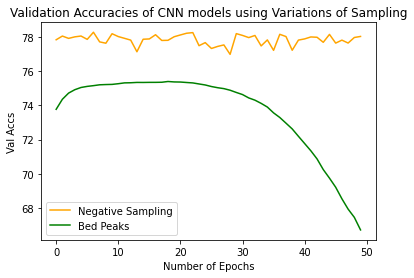

In [ ]:
plt.plot(binary_cnn_val_accs, label='Negative Sampling', color='orange')
plt.plot(binary_bedpeaks_val_accs, label="Bed Peaks", color='green')
plt.plot()
plt.legend() 

plt.title('Validation Accuracies of CNN models using Variations of Sampling')
plt.xlabel('Number of Epochs')
plt.ylabel('Val Accs') 

plt.savefig('binary_val_accs_CNN.png', dpi=300) 